# Putting things together 1

Here we will define a cell model with multiple sections and create a network model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neuron import h, gui, load_mechanisms

## Inspecting different neuron types
Let's put our cell model in a module.

In [2]:
%%file cell_models.py

from neuron import h
from cell_template import Cell

class Mainen(Cell):
    def __init__(self, i, rho=150, c=10):
        # We initialize the cell as in the `Cell` class.
        super().__init__()
        h.v_init = -70
        h.celsius = 37
        
        self.id = i
        self.set_rho(rho)
        self.set_c(c)

    def create_sections(self):
        self.soma = h.Section(name="soma", cell=self)
        self.dend = h.Section(name="dend", cell=self)

    def build_topology(self):
        self.dend.connect(self.soma(0.5), 0)

    def build_subsets(self):
        pass
    
    def define_geometry(self):
        self.soma.diam = 10/h.PI
        self.soma.L = 10
        self.dend.diam = 10/h.PI
        self.dend.L = 200
        
    def define_biophysics(self):
        self.soma.insert("na")
        self.soma.insert("kv")
        
        self.dend.insert("pas")
        self.dend.insert("na")
        self.dend.insert("ca")
        self.dend.insert("km")
        self.dend.insert("kca")
        self.dend.insert("cad")
        
        self.soma.ek = -90
        self.soma.ena = 60
        self.soma.gbar_na = 30000
        self.soma.gbar_kv = 1500

        self.dend.ek = -90
        self.dend.ena = 60
        self.dend.eca = 140
        h.ion_style("ca_ion", 0, 1, 0, 0, 0, sec=self.dend)

        self.dend.g_pas = 1/30000
        self.dend.gbar_na = 15
        self.dend.gbar_ca = 0.3
        self.dend.gbar_kca = 3
        self.dend.gbar_km = 0.1

        self.soma.cm = 0.75
        self.dend.cm = 0.75

    def set_rho(self, rho):
        self.rho = rho
        self.dend.L = self.rho*self.soma.L

    def set_c(self, c):
        self.c = c
        self.dend.Ra = self.dend.Ra*self.c/h.ri(.5, sec=self.dend)
        
    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.dend(0.5))) # AMPA
        self.synlist[-1].tau1 = 0.1
        self.synlist[-1].tau2 = 2.0
        self.synlist[-1].e = 0

        self.synlist.append(h.Exp2Syn(self.dend(0.5))) # NMDA-like
        self.synlist[-1].tau1 = 1.0
        self.synlist[-1].tau2 = 8.0
        self.synlist[-1].e = 0

        self.synlist.append(h.Exp2Syn(self.dend(0.5))) # GABA
        self.synlist[-1].e = -75
        self.synlist[-1].tau1 = 0.5
        self.synlist[-1].tau2 = 4.0
        
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # GABA
        self.synlist[-1].e = -75
        self.synlist[-1].tau1 = 0.5
        self.synlist[-1].tau2 = 4.0

Writing cell_models.py


We load the module and create a cell.

In [3]:
from cell_models import Mainen

cell = Mainen(0)

Let's inpect the cell's firing property with a current clamp.

In [4]:
ic = h.IClamp(0.5, sec=cell.soma)
ic.delay = 0
ic.dur   =  1000

def run(tstop=1000):
    
    h.tstop = tstop
    tvec = h.Vector()
    vsoma, vdend = [h.Vector() for _ in range(2)]
    
    vsoma.record(cell.soma(0.5)._ref_v, 0.01)
    vdend.record(cell.dend(0.5)._ref_v, 0.01)
    tvec.record(h._ref_t, 0.01)
    
    h.init()
    h.run()
    
    return (np.array(s.c().to_python()) for s in [tvec, vsoma, vdend])

This cell model has two properties, `rho` and `c`. `rho` is a ratio of the dendrite and somatic area. `c` is a coupling between two sections controlled by axial resistance. Let's first try a case of a relatively small dendritic section

Text(0, 0.5, 'voltage (mV)')

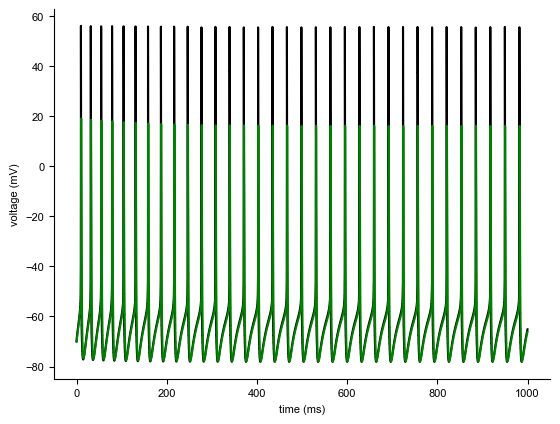

In [5]:
cell.set_rho(80)
cell.set_c(10)

ic.amp   =  100e-3

t, vsoma, vdend = run()

_, ax = plt.subplots()
ax.plot(t, vsoma, 'k')
ax.plot(t, vdend, 'g')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')

Let's increase the dendrite size.

Text(0, 0.5, 'voltage (mV)')

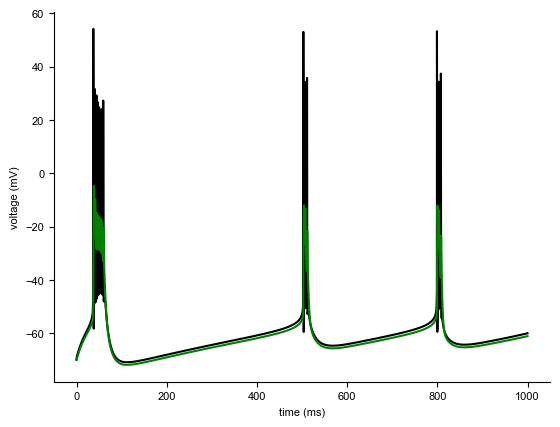

In [6]:
cell.set_rho(200)
cell.set_c(10)

ic.amp = 100e-3

t, vsoma, vdend = run()

_, ax = plt.subplots()
ax.plot(t, vsoma, 'k')
ax.plot(t, vdend, 'g')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')

Text(0, 0.5, 'voltage (mV)')

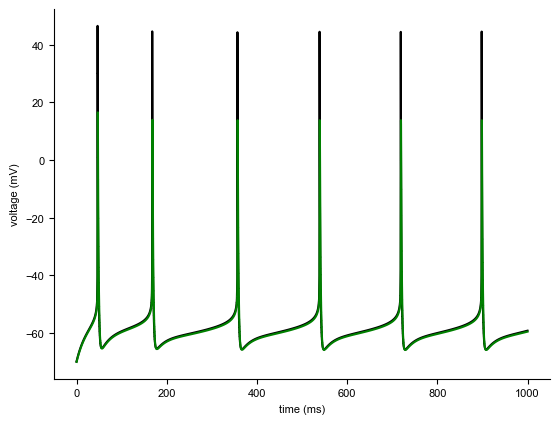

In [7]:
cell.set_rho(200)
cell.set_c(3)

ic.amp = 100e-3

t, vsoma, vdend = run()

_, ax = plt.subplots()
ax.plot(t, vsoma, 'k')
ax.plot(t, vdend, 'g')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')

Now let's see how the cell responds to (random) synaptic inputs.

In [8]:
stim = h.NetStimFD(cell.dend(0.5))
stim.interval = 3
stim.noise = 1
stim.start = 0
stim.duration = 1000

nc = h.NetCon(stim, cell.synlist[0])

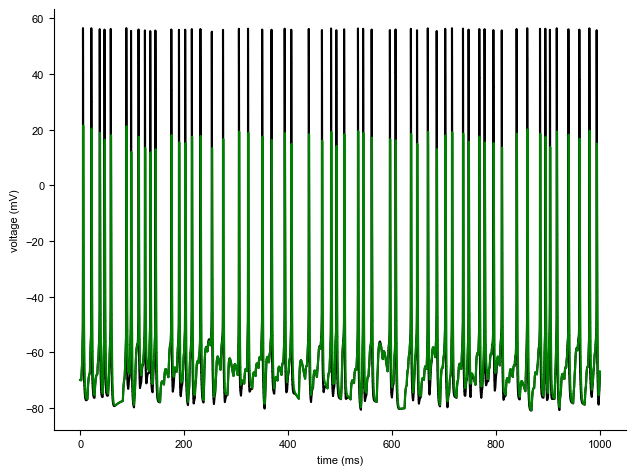

In [9]:
ic.amp = 0
cell.set_rho(80)
cell.set_c(10)

nc.weight[0] = 4e-3 # 4 nS

t, vsoma, vdend = run()

_, ax = plt.subplots()
ax.plot(t, vsoma, 'k', t, vdend, 'g')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')

plt.tight_layout()

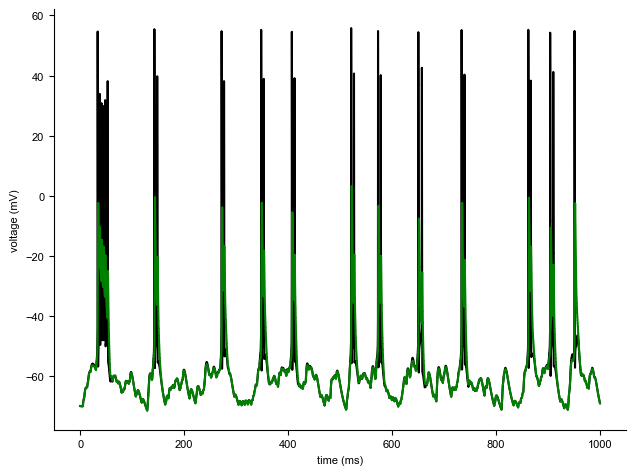

In [10]:
ic.amp = 0
cell.set_rho(200)
cell.set_c(10)

nc.weight[0] = 4e-3

t, vsoma, vdend = run()

_, ax = plt.subplots()
ax.plot(t, vsoma, 'k', t, vdend, 'g')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')

plt.tight_layout()

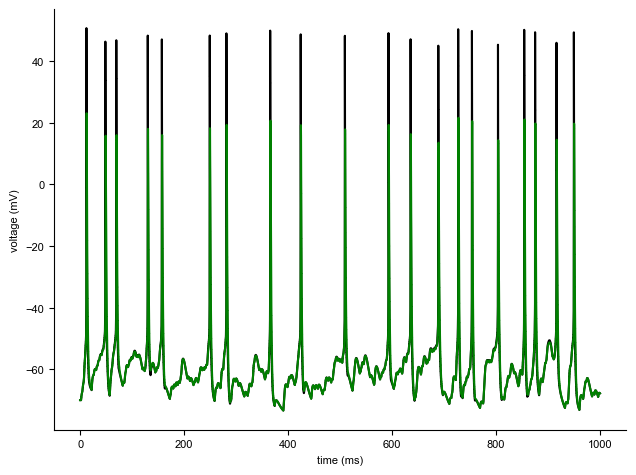

In [12]:
ic.amp = 0
cell.set_rho(200)
cell.set_c(3)

nc.weight[0] = 4e-3

t, vsoma, vdend = run()

_, ax = plt.subplots()
ax.plot(t, vsoma, 'k', t, vdend, 'g')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')

plt.tight_layout()